---
title: 12.12 风格迁移
date: 2024-10-14 14:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---

#### 

<!--more-->

# 12 风格迁移

- 将一个图像中的风格应用在另一图像之上

    - 需要两张输入图像：一张是内容图像，另一张是风格图像。

## 12.1 方法描述

1. 初始化合成图像，例如将其初始化为内容图像。( 该合成图像是风格迁移过程中唯一需要更新的变量，即风格迁移所需迭代的模型参数。 )

2. 选择一个预训练的卷积神经网络来抽取图像的特征，其中的模型参数在训练中无须更新。

    - 这个深度卷积神经网络凭借多个层逐级抽取图像的特征，我们可以选择其中某些层的输出作为内容特征或风格特征。
    - 如下图, 选取的预训练的神经网络含有3个卷积层，其中第二层输出内容特征，第一层和第三层输出风格特征。

    ![](../../../../../../themes/yilia/source/img/deeplearning/code/pytorch/12_computer_vision/12_style_transfoer/1.png)
    ![](img/deeplearning/code/pytorch/12_computer_vision/12_style_transfoer/1.png)

3. 通过前向传播（实线箭头方向）计算风格迁移的损失函数，并通过反向传播（虚线箭头方向）迭代模型参数

    - 风格迁移常用损失函数:
        - 内容损失使合成图像与内容图像在内容特征上接近
        - 风格损失使合成图像与风格图像在风格特征上接近
        - 全变分损失则有助于减少合成图像中的噪点


## 12.2 输入图像

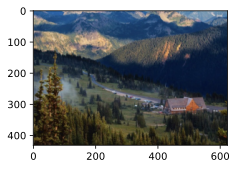

In [165]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
content_img = d2l.Image.open('./img/content.png')
d2l.plt.imshow(content_img)

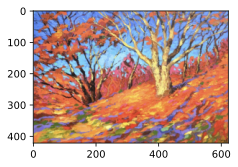

In [166]:
style_img = d2l.Image.open('./img/style.png')
d2l.plt.imshow(style_img)

## 12.3 预处理和后处理

- 预处理函数:
    - 对输入图像在RGB三个通道分别做标准化，并将结果变换成卷积神经网络接受的输入格式

- 后处理函数:
    - 将输出图像中的像素值还原回标准化之前的值

In [167]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    print(img.size)
    transforms = torchvision.transforms.Compose([ # 通过Compose实例将多个transform操作串联起来
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    print(transforms(img).size())
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1,2,0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2,0,1))

## 12.4 抽取图像特征

- 使用vgg19抽取特征

In [168]:
pretrained_net= torchvision.models.vgg19(pretrained=True)

c:\Users\admin\miniconda3\envs\d2l\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\miniconda3\envs\d2l\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


- 一般来说，越靠近输入层，越容易抽取图像的细节信息；反之，则越容易抽取图像的全局信息。为了避免合成图像过多保留内容图像的细节，我们选择VGG较靠近输出的层，即内容层，来输出图像的内容特征。

- 从VGG中选择不同层的输出来匹配局部和全局的风格，这些图层也称为风格层。

- VGG有5个卷积块, 我们选择第四卷积块的最后一个卷积层作为内容层，选择每个卷积块的第一个卷积层作为风格层。

In [169]:
# 查看网络结构
print(pretrained_net) #以MaxPool2d为分界线

#根据上面的输出可以知道应该选择哪些索引
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

- 使用VGG层抽取特征时，我们只需要用到**从输入层到最靠近输出层的内容层或风格层之间的所有层**。

In [170]:
net = nn.Sequential(
    *[
        pretrained_net.features[i] for i in range(max(content_layers + style_layers) + 1)
    ]
)

- 给定输入X，如果我们简单地调用前向传播net(X)，只能获得最后一层的输出。由于我们还需要中间层的输出，因此这里我们逐层计算，并保留内容层和风格层的输出。

In [171]:
# 获取所有风格层和内容层的输出
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

- 定义两个函数:
    - 对内容图像抽取内容特征
    - 对风格图像抽取风格特征

In [172]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## 12.5 定义损失函数

### 12.5.1 内容损失

- 内容损失通过平方误差函数衡量合成图像与内容图像在内容特征上的差异。



In [173]:
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()

### 12.5.2 风格损失
- 风格损失也通过平方误差函数衡量

- 假设风格特征为[1, c, h ,w]的矩阵, 则将其转换为:X[c, h * w]

    - X可以看成由c个向量组成, 每个向量代表不同通道上的风格特征

    - 格拉姆矩阵: $X X^T$的元素$x_{ij}$即为$x_i$和$x_j$的内积, 表达了通道i和通道j上风格特征的相关性.
```
x = [
    [1, 2, 3, 4, 5, 6, 7, 8, 9],
    [2, 3, 4, 5, 6, 7, 8, 9, 10],
    [3, 4, 5, 6, 7, 8, 9, 10, 11],
    [4, 5, 6, 7, 8, 9, 10, 11, 12]
]
x^T = [
    [1, 2, 3, 4],
    [2, 3, 4, 5],
    [3, 4, 5, 6],
    [4, 5, 6, 7],
    [5, 6, 7, 8],
    [6, 7, 8, 9],
    [7, 8, 9, 10],
    [8, 9, 10, 11],
    [9, 10, 11, 12]
]
x x^T = [
    [285, 335, 385, 435],
    [335, 395, 455, 515],
    [385, 455, 525, 595],
    [435, 515, 595, 675]
]
```

    - 可以看到当hw的值较大时，格拉姆矩阵中的元素容易出现较大的值。为了让风格损失不受这些值的大小影响，下面定义的gram函数将格拉姆矩阵除以了矩阵中元素的个数，即chw。

In [174]:
def gram(X):
    num_channels,n = X.shape[1], X.numel()//X.shape[1] #X.numel()返回X中元素的总数, numel/shape[1] = b*h*w
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

- 风格损失计算两个gram矩阵之间的均方误差
    - 合成图像的gram矩阵
    - 风格图像的gram矩阵

In [175]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

### 12.5.3 全变分损失

- 有时候，我们学到的合成图像里面有大量高频噪点，即有特别亮或者特别暗的颗粒像素。

- 一种常见的去噪方法是全变分去噪（totalvariationdenoising）:
    - 假设$x_{i,j}$表示坐标为(i,j)的像素值，降低全变分损失能够尽可能使邻近的像素值相似

    $$ \sum_{i,j} |x_{i+1,j} - x_{i,j}| + |x_{i,j+1} - x_{i,j}| $$

In [176]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean()) #矩阵.mean()返回矩阵所有元素的平均值, 0.5为了归一化
test = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
print(test.mean())

tensor(3.5000)


### 12.5.4 损失函数

- 加权和:
    - 内容损失
    - 风格损失
    - 全变分损失

In [177]:
content_weight, style_weight, tv_weight = 1, 1e3, 10
def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 计算内容损失
    contents_l = [content_loss(Y_hat, Y)* content_weight for Y_hat, Y in zip(contents_Y_hat, contents_Y)]
    #print(len(contents_Y)) #1
    # 计算风格损失
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(styles_Y_hat, styles_Y_gram)]
    #print(len(styles_Y_gram)) #5
    # 计算全变分损失
    tv_l = tv_loss(X) * tv_weight # 这里的X是生成的图像
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

## 12.6 初始化合成图像

- 在风格迁移中，合成的图像是训练期间唯一需要更新的变量。因此，我们可以定义一个简单的模型, 将合成的图像视为模型参数。模型的前向传播只需返回模型参数即可。

In [178]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape)) # 按照img_shape的形状生成一个随机矩阵

    def forward(self):
        return self.weight
    
# 初始化图像, 获得风格图的gram矩阵
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device) #网络实例化
    gen_img.weight.data.copy_(X.data) #将内容图像作为初始生成图像
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

## 12.7 训练模型

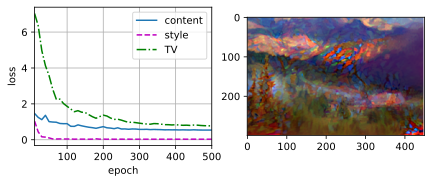

In [179]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8) # 每lr_decay_epoch个epoch，学习率乘以0.8
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs], legend=['content', 'style', 'TV'], ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)
        contents_l, style_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)), float(sum(style_l)), float(tv_l)])
    return X

device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)
